In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.metrics import confusion_matrix
# from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string 
import nltk 

In [2]:
df = pd.read_csv('/kaggle/input/text-based-cyber-threat-detection/cyber-threat-intelligence_all.csv')

In [3]:
df.head()

,Unnamed: 0,index,text,entities,relations,Comments,id,label,start_offset,end_offset
0,0,1.0,This post is also available in: 日本語 (Japa...,"[{'id': 45800, 'label': 'malware', 'start_offs...",[],[],45800.0,malware,288.0,300.0
1,1,2.0,The attack vector is very basic and repeats it...,"[{'id': 48941, 'label': 'attack-pattern', 'sta...",[],[],48941.0,attack-pattern,69.0,115.0
2,2,3.0,Once executed by the user the first stage malw...,[],[],[],NaN,NaN,NaN,NaN
3,3,4.0,The first known campaign was launched by Crim...,"[{'id': 45806, 'label': 'TIME', 'start_offset'...",[],[],45806.0,TIME,55.0,68.0
4,4,5.0,The first stage downloaded the ransomware from...,[],[],[],NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 19940 entries, 0 to 19939

Data columns (total 10 columns):

 #   Column        Non-Null Count  Dtype  

---  ------        --------------  -----  

 0   Unnamed: 0    19940 non-null  int64  

 1   index         19464 non-null  float64

 2   text          19940 non-null  object 

 3   entities      19464 non-null  object 

 4   relations     19464 non-null  object 

 5   Comments      19464 non-null  object 

 6   id            9462 non-null   float64

 7   label         9938 non-null   object 

 8   start_offset  9462 non-null   float64

 9   end_offset    9462 non-null   float64

dtypes: float64(4), int64(1), object(5)

memory usage: 1.5+ MB


In [5]:
df=df.drop(labels='Unnamed: 0',axis=1)

In [6]:
df['label'].fillna(value='benign', inplace=True)

In [7]:
df=df.fillna(0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 19940 entries, 0 to 19939

Data columns (total 9 columns):

 #   Column        Non-Null Count  Dtype  

---  ------        --------------  -----  

 0   index         19940 non-null  float64

 1   text          19940 non-null  object 

 2   entities      19940 non-null  object 

 3   relations     19940 non-null  object 

 4   Comments      19940 non-null  object 

 5   id            19940 non-null  float64

 6   label         19940 non-null  object 

 7   start_offset  19940 non-null  float64

 8   end_offset    19940 non-null  float64

dtypes: float64(4), object(5)

memory usage: 1.4+ MB


In [9]:
df['label'].unique()

array(['malware', 'attack-pattern', 'benign', 'TIME', 'identity',
       'SOFTWARE', 'threat-actor', 'location', 'tools', 'FILEPATH',
       'SHA2', 'vulnerability', 'URL', 'DOMAIN', 'IPV4', 'campaign',
       'EMAIL', 'REGISTRYKEY', 'SHA1', 'Infrastucture', 'MD5', 'url',
       'hash'], dtype=object)

In [10]:
data = df[['text','label']]

In [11]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

In [12]:
def preprocess_text(text):
    tokens = word_tokenize(text)

    tokens = [token.lower() for token in tokens if token not in punctuations]

    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    tokens = [token for token in tokens if token not in stop_words]

    processed_text = ' '.join(tokens)
    
    return processed_text

In [13]:
data['text_new'] = data['text'].apply(preprocess_text)

C:\Users\Fenil\AppData\Local\Temp\ipykernel_9920\3005584527.py:1: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['text_new'] = data['text'].apply(preprocess_text)


In [14]:
data = data.drop(labels=['text'],axis=1)

In [15]:
data['text_new'] = data['text_new'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

In [16]:
data.head()

,label,text_new
0,malware,post also available japanese ctblocker wellkn...
1,attack-pattern,attack vector basic repeat begin spear phishin...
2,benign,executed user first stage malware downloads ex...
3,TIME,first known campaign wa launched crimeware nov...
4,benign,first stage downloaded ransomware site


In [17]:
data.shape

(19940, 2)

In [18]:
data.label.loc[(data['label']=="MD5") | (data['label']=="REGISTRYKEY") | (data['label']=="EMAIL") |  (data['label']=="Infrastucture") | (data['label']=="DOMAIN") | (data['label']=="SHA1") | (data['label']=="IPV4") | (data['label']=="campaign") | (data['label']=="URL") | (data['label']=="SHA2") | (data['label']=="vulnerability") | (data['label']=="FILEPATH") | (data['label']=="tools") | (data['label']=="TIME") | (data['label']=="url") | (data['label']=="hash") ] = "NEED_ATTENTION"

In [19]:
data['label'].value_counts()

benign            10002
NEED_ATTENTION     2132
malware            1911
location           1405
SOFTWARE           1229
attack-pattern     1206
identity           1165
threat-actor        890
Name: label, dtype: int64

In [25]:
data.label.value_counts()

benign            10002
NEED_ATTENTION     2132
malware            1911
location           1405
SOFTWARE           1229
attack-pattern     1206
identity           1165
threat-actor        890
Name: label, dtype: int64

In [26]:
data['text_new'][0]

'post also available  japanese ctblocker wellknown ransomware trojan used crimeware group encrypt file victim s endpoint demand ransom payment decrypt file back original state antiviruses detect mistake cryptolocker one vendor correctly detects ctblocker'

In [27]:
max_length = data['text_new'].str.len().max()
max_length

4655

In [28]:
max_length_tokens = data['text_new'].apply(lambda x: len(x.split())).max()

In [29]:
max_length_characters = data['text_new'].apply(lambda x: len(x)).max()

print('Maximum Sequence Length (Tokens):', max_length_tokens)
print('Maximum Sequence Length (Characters):', max_length_characters)

Maximum Sequence Length (Tokens): 451

Maximum Sequence Length (Characters): 4655


In [30]:
MAX_NB_WORDS = 50000
MAX_SEQ_LENGTH = 450
EMBEDDING_DIM=100

In [31]:
data = data.rename(columns={'text_new': 'text'})

In [32]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%()*+,-./:;<=>?@[\]^_`{|}',lower=True)
tokenizer.fit_on_texts(data['text'].values)

In [33]:
word_index = tokenizer.word_index
len(word_index)

11934

In [34]:
X = tokenizer.texts_to_sequences(data['text'].values) 
X = pad_sequences(X,maxlen=MAX_SEQ_LENGTH)

In [35]:
X 

array([[   0,    0,    0, ..., 1943, 1718, 4837],
       [   0,    0,    0, ...,  343, 1916, 6560],
       [   0,    0,    0, ...,  533,   18,  181],
       ...,
       [   0,    0,    0, ...,  257,    2,   18],
       [   0,    0,    0, ..., 1374, 1828, 2238],
       [   0,    0,    0, ...,   16,   26,   39]])

In [36]:
X.shape

(19940, 450)

In [37]:
Y = pd.get_dummies(data['label']).values

In [38]:
from sklearn.preprocessing import LabelBinarizer
# Perform one-hot encoding using LabelBinarizer
lb = LabelBinarizer()
Y = lb.fit_transform(data['label'])

In [39]:
Y 

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [40]:
Y.shape 

(19940, 8)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=42)

In [112]:
model=Sequential()
model.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=X.shape[1]))
model.add(LSTM(150,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(8,activation='softmax'))

In [113]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [114]:
model.summary()

Model: "sequential_18"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_18 (Embedding)    (None, 450, 100)          5000000   

                                                                 

 lstm_18 (LSTM)              (None, 150)               150600    

                                                                 

 dropout_18 (Dropout)        (None, 150)               0         

                                                                 

 dense_19 (Dense)            (None, 8)                 1208      

                                                                 


Total params: 5151808 (19.65 MB)

Trainable params: 5151808 (19.65 MB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________


In [105]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [45]:
epochs=10
batch_size=64
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10

200/200 [==============================] - 704s 4s/step - loss: 1.4478 - accuracy: 0.5254 - val_loss: 1.2594 - val_accuracy: 0.5691

Epoch 2/10

200/200 [==============================] - 763s 4s/step - loss: 0.9705 - accuracy: 0.6774 - val_loss: 0.8914 - val_accuracy: 0.7249

Epoch 3/10

200/200 [==============================] - 2743s 14s/step - loss: 0.5269 - accuracy: 0.8373 - val_loss: 0.7021 - val_accuracy: 0.8048

Epoch 4/10

200/200 [==============================] - 786s 4s/step - loss: 0.3181 - accuracy: 0.9054 - val_loss: 0.6467 - val_accuracy: 0.8270

Epoch 5/10

200/200 [==============================] - 805s 4s/step - loss: 0.2158 - accuracy: 0.9382 - val_loss: 0.6438 - val_accuracy: 0.8455

Epoch 6/10

200/200 [==============================] - 846s 4s/step - loss: 0.1664 - accuracy: 0.9506 - val_loss: 0.6430 - val_accuracy: 0.8580

Epoch 7/10

200/200 [==============================] - 869s 4s/step - loss: 0.1338 - accuracy: 0.9580 - val_loss: 0.6409 - val_a

In [46]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

125/125 [==============================] - 22s 174ms/step - loss: 0.6045 - accuracy: 0.8526

Test set

  Loss: 0.605

  Accuracy: 0.853


In [47]:
predictions = model.predict(x_test)
for i in range(5):
    print('Prediction: {}'.format(predictions[i]))
    print('Actual: {}'.format(y_test[i]))

125/125 [==============================] - 17s 136ms/step

Prediction: [9.6318454e-01 2.9663841e-04 2.5312418e-05 1.3646387e-06 2.2998016e-05

 1.3450538e-04 3.6318723e-02 1.5957614e-05]

Actual: [1 0 0 0 0 0 0 0]

Prediction: [8.6590729e-04 7.9993944e-05 3.6189002e-05 9.9892944e-01 6.6794591e-06

 4.2900403e-05 2.7041237e-05 1.1825840e-05]

Actual: [0 0 0 1 0 0 0 0]

Prediction: [2.9950363e-05 5.1271069e-05 1.0583154e-04 4.7303809e-05 5.4122866e-06

 9.2615164e-04 9.9863499e-01 1.9907784e-04]

Actual: [0 0 0 0 0 0 1 0]

Prediction: [2.8206425e-04 8.3369970e-01 2.6026429e-04 1.6349821e-01 6.2664505e-05

 4.4351789e-05 2.1418245e-03 1.0942039e-05]

Actual: [0 1 0 0 0 0 0 0]

Prediction: [2.7366175e-05 2.8586092e-05 2.2904471e-05 9.9987113e-01 2.0361285e-05

 7.0562342e-06 1.3209977e-05 9.4366942e-06]

Actual: [0 0 0 1 0 0 0 0]


In [49]:
import matplotlib.pyplot as plt

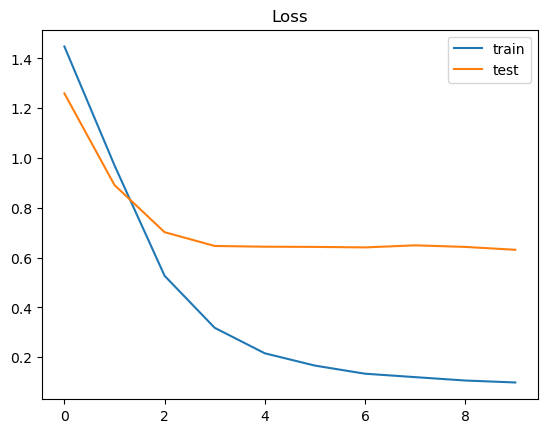

In [50]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [52]:
y_pred = np.argmax(model.predict(x_test), axis=1)

125/125 [==============================] - 11s 86ms/step


In [55]:
class_labels = lb.classes_

print(class_labels)

['NEED_ATTENTION' 'SOFTWARE' 'attack-pattern' 'benign' 'identity'

 'location' 'malware' 'threat-actor']


125/125 [==============================] - 10s 83ms/step


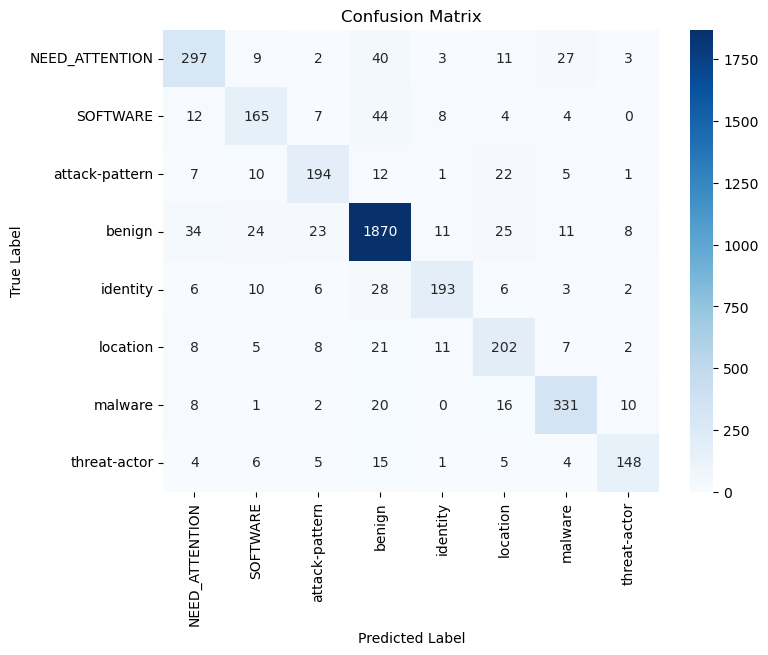

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

cm = confusion_matrix(y_true, y_pred)

classes = np.arange(len(cm))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [122]:
print('hi')

hi


In [57]:
accuracy = (cm.diagonal().sum()) / cm.sum()
accuracy

0.8525576730190572

In [58]:
precision = cm.diagonal() / cm.sum(axis=0)
precision

array([0.78989362, 0.7173913 , 0.7854251 , 0.91219512, 0.84649123,
       0.69415808, 0.84438776, 0.85057471])

In [59]:
recall = cm.diagonal() / cm.sum(axis=1)
recall

array([0.75765306, 0.67622951, 0.76984127, 0.93220339, 0.75984252,
       0.76515152, 0.85309278, 0.78723404])

In [60]:
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score

array([0.7734375 , 0.69620253, 0.77755511, 0.92209073, 0.80082988,
       0.72792793, 0.84871795, 0.81767956])

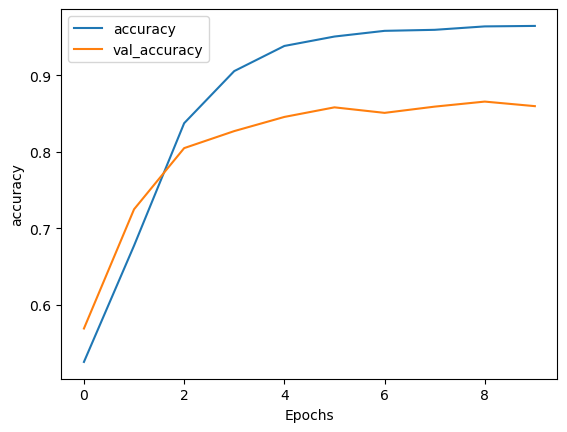

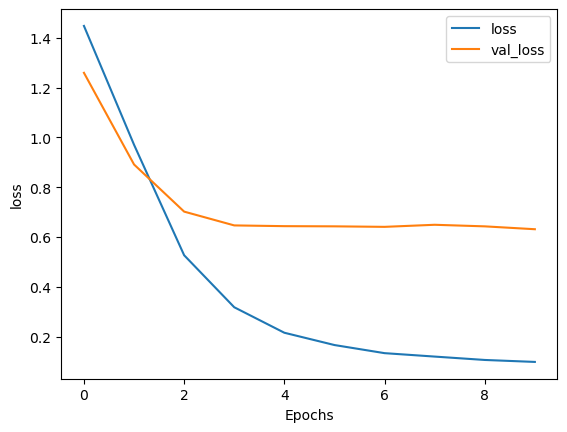

In [65]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

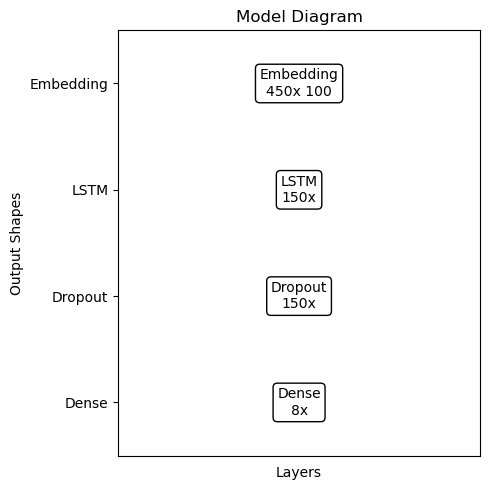

In [81]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

# Create the model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

# Function to plot the model diagram
def plot_model_diagram(model):
    layer_names = [layer.__class__.__name__ for layer in model.layers]
    output_shapes = [layer.output_shape[1:] for layer in model.layers]

    plt.figure(figsize=(5, 5))
    plt.title("Model Diagram")
    plt.xlabel("Layers")
    plt.ylabel("Output Shapes")

    for i, (layer_name, output_shape) in enumerate(zip(layer_names, output_shapes)):
        output_shape_str = str(output_shape).replace(",", "x").replace("(", "").replace(")", "")

        plt.text(0.5, i, f"{layer_name}\n{output_shape_str}",
                 horizontalalignment='center',
                 verticalalignment='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.yticks(range(len(layer_names)), layer_names)
    plt.xticks([])
    plt.ylim(len(layer_names) - 0.5, -0.5)  # Reverse y-axis
    plt.tight_layout()
    plt.show()

# Generate the model diagram
plot_model_diagram(model)


# new fit

In [61]:
model1=Sequential()
model1.add(Embedding(MAX_NB_WORDS,EMBEDDING_DIM,input_length=X.shape[1]))
model1.add(LSTM(150,dropout=0.2,recurrent_dropout=0.2))
model1.add(Dropout(0.2))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(8,activation='softmax')) 

In [62]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
model1.summary()

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, 450, 100)          5000000   

                                                                 

 lstm_1 (LSTM)               (None, 150)               150600    

                                                                 

 dropout_1 (Dropout)         (None, 150)               0         

                                                                 

 dense_1 (Dense)             (None, 64)                9664      

                                                                 

 dense_2 (Dense)             (None, 8)                 520       

                                                                 


Total params: 5160784 (19.69 MB)

Trainable params: 5160784 (19.69 MB)

Non-trainable params: 0 (0.00 Byte)

______________________________________________________________

In [68]:
epochs=15
batch_size=75
history = model1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [415]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

125/125 [==============================] - 35s 283ms/step - loss: 2.0801 - accuracy: 0.0968

Test set

  Loss: 2.080

  Accuracy: 0.097


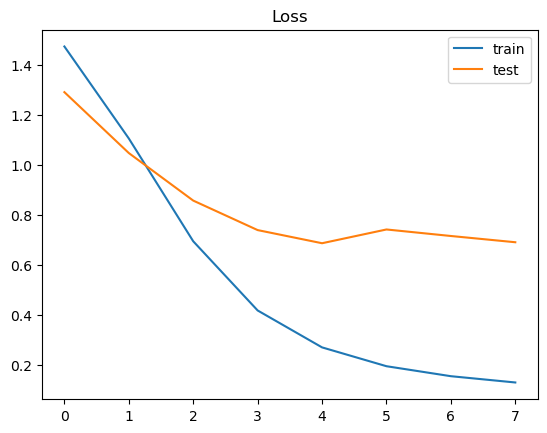

In [366]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [418]:
y_pred = np.argmax(model.predict(x_test), axis=1)

125/125 [==============================] - 32s 260ms/step


In [419]:
accuracy = (cm.diagonal().sum()) / cm.sum()
accuracy

0.09679037111334002

In [420]:
precision = cm.diagonal() / cm.sum(axis=0)
precision

array([0.07339956, 0.02702703, 0.03301887, 0.42138365, 0.12980769,
       0.08310249, 0.0720339 , 0.05169628])

In [421]:
recall = cm.diagonal() / cm.sum(axis=1)
recall

array([0.33928571, 0.02459016, 0.02777778, 0.0667996 , 0.10629921,
       0.11363636, 0.04381443, 0.17021277])

In [422]:
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score

array([0.12068966, 0.02575107, 0.03017241, 0.11531842, 0.11688312,
       0.096     , 0.05448718, 0.07930607])

In [423]:
class_labels = lb.classes_

print(class_labels)

['NEED_ATTENTION' 'SOFTWARE' 'attack-pattern' 'benign' 'identity'

 'location' 'malware' 'threat-actor']


125/125 [==============================] - 33s 263ms/step


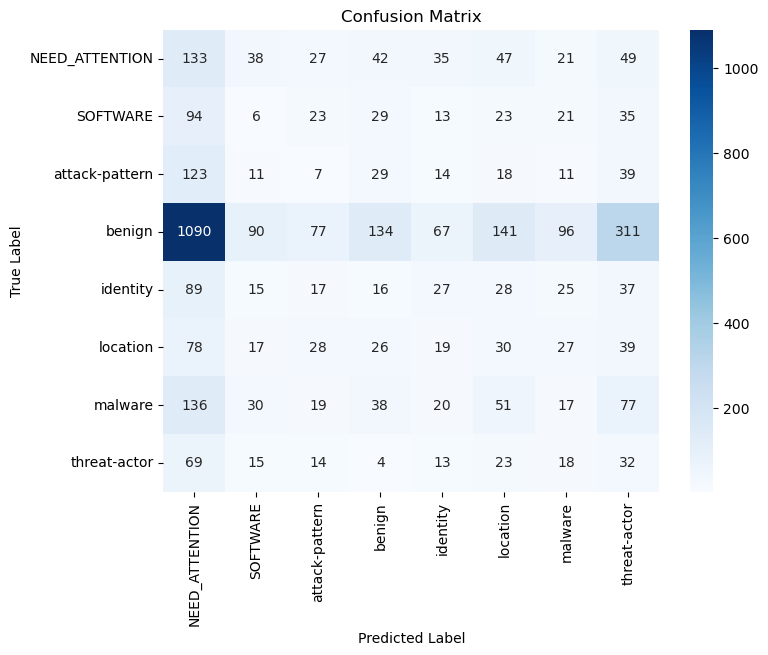

In [424]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

cm1 = confusion_matrix(y_true, y_pred)

classes = np.arange(len(cm))

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [425]:
y_pred.shape

(3988,)

In [426]:
y_true.shape

(3988,)

In [427]:
accuracy = (cm.diagonal().sum()) / cm.sum()
accuracy

0.09679037111334002

In [428]:
precision = cm.diagonal() / cm.sum(axis=0)
precision

array([0.07339956, 0.02702703, 0.03301887, 0.42138365, 0.12980769,
       0.08310249, 0.0720339 , 0.05169628])

In [429]:
recall = cm.diagonal() / cm.sum(axis=1)
recall

array([0.33928571, 0.02459016, 0.02777778, 0.0667996 , 0.10629921,
       0.11363636, 0.04381443, 0.17021277])

In [430]:
f1_score = 2 * (precision * recall) / (precision + recall)
f1_score

array([0.12068966, 0.02575107, 0.03017241, 0.11531842, 0.11688312,
       0.096     , 0.05448718, 0.07930607])

In [431]:
class_labels = lb.classes_

print(class_labels)

['NEED_ATTENTION' 'SOFTWARE' 'attack-pattern' 'benign' 'identity'

 'location' 'malware' 'threat-actor']


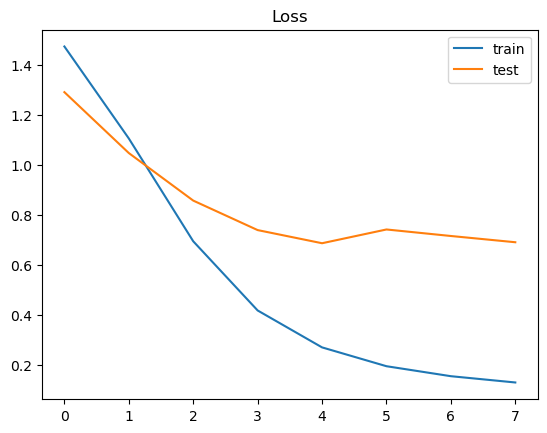

In [373]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

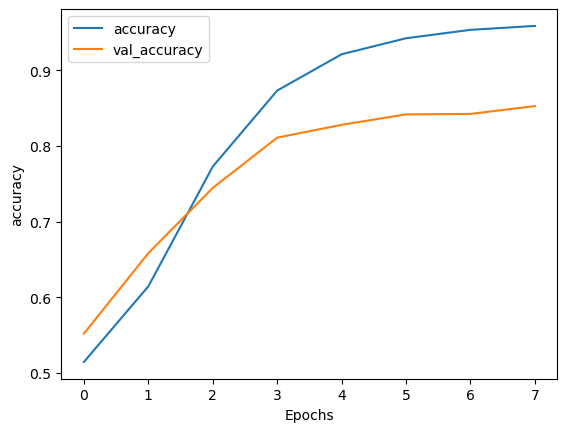

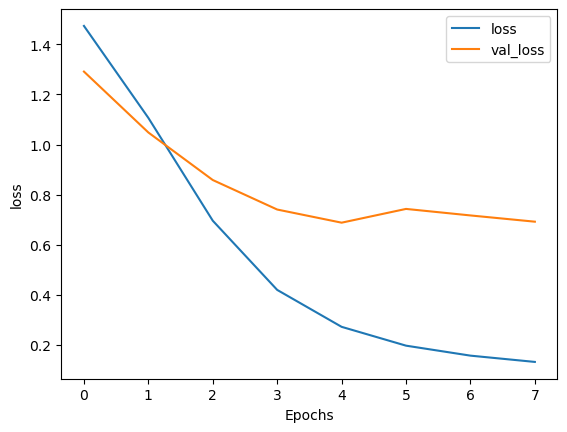

In [374]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Another notebook with LSTM, RNN, and GRU models will be released soon along with different Optimizers training.